# Import lib

In [1]:
import pythonradex


# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from tqdm import tqdm
from scipy import constants

from scipy.stats import norm

# libraries to remove unecessary printings coused by radex
import contextlib
import io

import os
import pandas as pd
import sys

# Initial setup

In [2]:
# ============================
# (1) Set up the "true" simulation
# ============================

# Path to the molecular data file (CH3OH from the LAMDA database)
datafilepath_methanol = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\e_ch3oh.dat"

data_methanol = LAMDA_file.read(datafilepath_methanol, read_frequencies=False)

# Geometry and line profile
geometry = "uniform sphere"
line_profile_type = "Gaussian"

# True simulation parameters (using your constants)
N = 1e16 / constants.centi**2  # CH3OH_e column density in m^-2
width_v = 4 * constants.kilo  # line width in m/s (1 km/s * 2)
Tkin = 120  # kinetic temperature in K

observed_spectrum_n_collider = 1e8  # collider density in cm^-3
LTE_collider_densities_h2only = {"H2": observed_spectrum_n_collider / constants.centi**3}  # collider density in m^-3
T_dust = 0
tau_dust = 0
ext_background = helpers.generate_CMB_background(z=0)

# Create the "true" cloud object using your variable names
cloud_metahnol = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)
cloud_metahnol.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)
with contextlib.redirect_stdout(io.StringIO()):
    cloud_metahnol.solve_radiative_transfer()


# Define a helper function to extract values from the cloud and data file
def extract_values(cloud_name, data_of_molecule):
    # Excitation temperature and optical depth
    Tex = cloud_name.Tex
    tau = cloud_name.tau_nu0_individual_transitions
    # Einstein coefficients and transition frequencies
    Aul = cloud_name.emitting_molecule.A21
    Bul = cloud_name.emitting_molecule.B21
    nu0_array = cloud_name.emitting_molecule.nu0
    # Extract level energies (convert from Joule to Kelvin)
    levels = data_of_molecule["levels"]
    Eu = np.array([level.E for level in levels]) / constants.k
    Eu = Eu[1:]  # remove first component (nan)
    g_weigth = np.array([level.g for level in levels])[1:]

    return Tex, tau, Aul, Bul, nu0_array, Eu, g_weigth


TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH = extract_values(cloud_metahnol, data_methanol)

# For simplicity, take only the first 10 transitions
firstN_transitions = 30
TexCH3OH = TexCH3OH[:firstN_transitions]
tauCH3OH = tauCH3OH[:firstN_transitions]
AulCH3OH = AulCH3OH[:firstN_transitions]
BulCH3OH = BulCH3OH[:firstN_transitions]
nu0_arrayCH3OH = nu0_arrayCH3OH[:firstN_transitions]
EuCH3OH = EuCH3OH[:firstN_transitions]
gCH3OH = gCH3OH[:firstN_transitions]

# Compute the fluxes from the cloud
distance_observer = 100 * constants.parsec  # observer distance in m
source_radius = 10 * constants.au  # source radius in m
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

flux_methanol = cloud_metahnol.fluxes_of_individual_transitions(transitions=list(range(firstN_transitions)), solid_angle=source_solid_angle)
# Define an arbitrary fwhm in frequency (using the first transition as reference)
fwhm_frequancy = nu0_arrayCH3OH[0] * 0.2

# Choose a specific transition (e.g. transition 2) for the MCMC fit
choose_transition = 2


# Define a Gaussian function (as in your code)
def gaussian(x, amp, cen, fwhm):
    """Gaussian function with amplitude, center, and FWHM as parameters

    Parameters
    ----------
    x : array_like
        The frequency axis
    amp : float
        Amplitude of the Gaussian
    cen : float
        Center of the Gaussian
    fwhm : float
        Full Width at Half Maximum of the Gaussian

    Returns
    -------
    array_like
        The Gaussian function evaluated at the frequency axis x
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amp * np.exp(-((x - cen) ** 2) / (2 * sigma**2))


c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'
c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


# Plot spectum

In [3]:
def model_spectrum(x, params):
    """
    Create spectrum, sum of Gaussians.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        params: list or array of parameters. For n Gaussians, params should be of length 3*n,
                where each Gaussian has [amp, cen, fwhm] in order.

    Returns:
        The sum of Gaussians evaluated at x.
    """
    n_gauss = len(params) // 3
    total = np.zeros_like(x)
    for i in range(n_gauss):
        amp = params[3 * i]
        cen = params[3 * i + 1]
        fwhm = params[3 * i + 2]
        total += gaussian(x, amp, cen, fwhm)
    return total

In [4]:
realistic_fwhm = nu0_arrayCH3OH * (width_v / constants.c)

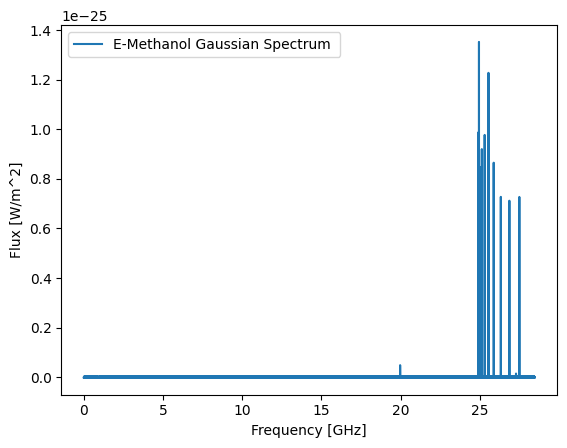

In [9]:
# number of transitions to plot in spectrum
n_trans_spectrum = 29

# generate frequency space
x = np.linspace(0, nu0_arrayCH3OH[n_trans_spectrum] * 1.01, int(1e5))

# compute the offset using V_LSR
# V_LSR = 0.0001 * constants.c
V_LSR = 0.3

nu0_arrayCH3OH_observed = nu0_arrayCH3OH * (1 - (V_LSR * 100) / constants.c)

params_observed = []
params_rest = []
for i in range(n_trans_spectrum):
    params_observed.extend([flux_methanol[i], nu0_arrayCH3OH_observed[i], realistic_fwhm[i]])
    # params_rest.extend([flux_methanol[i], nu0_arrayCH3OH[i], realistic_fwhm[i]])

# Generate the spectra
no_noise_spectrum_observed = model_spectrum(x, params_observed)
# no_noise_spectrum_rest = model_spectrum(x, params_rest)

noise_std_observed = 0.0005 * np.max(no_noise_spectrum_observed)
# noise_std_rest = 0.0005 * np.max(no_noise_spectrum_rest)

observed_spectrum = no_noise_spectrum_observed + np.random.normal(0, noise_std_observed, len(x))
# spectrum_rest = no_noise_spectrum_rest + np.random.normal(0, noise_std_rest, len(x))

# Plot the spectra
fig, ax = plt.subplots()
plt.plot(x / constants.giga, observed_spectrum, label="E-Methanol Gaussian Spectrum ")
# plt.plot(x / constants.giga, spectrum_rest, label="Gaussian Spectrum with Rest nu")
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"Flux [W/m^2]")
plt.legend()
plt.show()

In [6]:
V_LSR_cpersentage = (V_LSR) / constants.c
print(f"V_LSR in persentage of speed of light: {V_LSR_cpersentage}%")

V_LSR in persentage of speed of light: 1.0006922855944562e-09%


# Define the MCMC model functions

In [7]:
cloud_candidate = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)


def simulate_spectrum_from_params(Tkin_candidate, log_n_H2_candidate, V_LSR, width_v_candidate, debug=False):
    """Simulate a spectrum from multiple transitions for a given set of parameters

    Parameters
    ----------
    Tkin_candidate : float
        Kinetic temperature of the candidate cloud in K
    log_n_H2_candidate : float
        Logarithm of the H2 density of the candidate cloud in cm^-3
    V_LSR : float
        The velocity of the candidate cloud in km/s
    debug : bool, optional
        Print debug information, by default False"""

    # Convert log-density to linear density (matching your units)
    n_H2_candidate = 10 ** (log_n_H2_candidate) / constants.centi**3
    # Create a new cloud with the candidate width_v

    # check the parameter ranges
    assert 20 < Tkin_candidate < 500, f"Tkin_candidate out of range: {Tkin_candidate}"
    assert 2 < log_n_H2_candidate < 10, f"log_n_H2_candidate out of range: {log_n_H2_candidate}"
    # assert 0 < nu < 2000, f"nu_offset out of range: {nu}"

    cloud_candidate.update_parameters(
        N=N,
        Tkin=Tkin_candidate,
        collider_densities={"H2": n_H2_candidate},
        ext_background=ext_background,
        T_dust=T_dust,
        tau_dust=tau_dust,
    )
    # Suppress the print statements in solve_radiative_transfer
    with contextlib.redirect_stdout(io.StringIO()):
        cloud_candidate.solve_radiative_transfer()
    # Get the flux for the chosen transition
    flux_candidate = cloud_candidate.fluxes_of_individual_transitions(transitions=list(range(firstN_transitions)), solid_angle=source_solid_angle)

    # move the rest nu by V_LSR
    nu = nu0_arrayCH3OH * (1 - (V_LSR * 100) / constants.c)

    # width in freqancy space
    fwhm_candidate = nu0_arrayCH3OH * (width_v_candidate / constants.c)
    params = []
    for i in range(n_trans_spectrum):
        params.extend([flux_candidate[i], nu[i], fwhm_candidate[i]])

    # print("flux of spectrum ", flux_candidate)
    if debug:
        print("params ", params)
        print("nu ", nu)

    # Build the model line using the same Gaussian profile (center and fwhm_frequancy fixed)
    model_all_spectrum = model_spectrum(x, params)
    return model_all_spectrum

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'


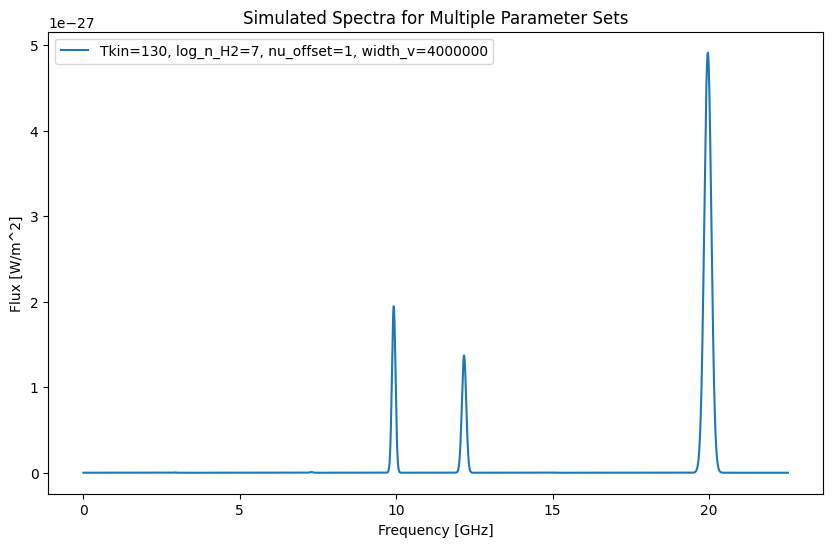

In [8]:
# Define multiple sets of parameters
# parameter_sets = [(130, 7, 1), (130, 7, 300), (130, 7, 50)]
parameter_sets = [(130, 7, 1, 4000000)]
# parameter_sets = [(130, 7, 1)]

# Plot all spectra
plt.figure(figsize=(10, 6))
for Tkin_candidate, log_n_H2_candidate, nu_offsets, width_v_test in parameter_sets:
    spec = simulate_spectrum_from_params(Tkin_candidate, log_n_H2_candidate, nu_offsets, width_v_test)
    plt.plot(x / constants.giga, spec, label=f"Tkin={Tkin_candidate}, log_n_H2={log_n_H2_candidate}, nu_offset={nu_offsets}, width_v={width_v_test}")

plt.xlabel("Frequency [GHz]")
plt.ylabel(r"Flux [W/m^2]")
plt.legend()
plt.title("Simulated Spectra for Multiple Parameter Sets")
plt.show()

# Define log_likelihood, log_prior and log_probability


In [9]:
def log_likelihood_radex(theta, x, y, yerr):
    Tkin_candidate, log_n_H2_candidate, vlsr_candidate, width_v_candidate = theta
    # print(f"Evaluating log_likelihood with theta: {theta}")
    model = simulate_spectrum_from_params(Tkin_candidate, log_n_H2_candidate, vlsr_candidate, width_v_candidate)
    log_likelihood_value = -0.5 * np.sum(((y - model) / yerr) ** 2)
    # print(f"log_likelihood: {log_likelihood_value}")
    return log_likelihood_value


def log_prior(theta):
    Tkin_candidate, log_n_H2_candidate, vlsr_candidate, width_v_candidate = theta
    # print(f"Checking log_prior with Tkin_candidate={Tkin_candidate}, log_n_H2_candidate={log_n_H2_candidate}, vlsr_candidate={vlsr_candidate}")

    if 20 < Tkin_candidate < 300 and 5 < log_n_H2_candidate < 9 and 0 < vlsr_candidate < 3 and 500 < width_v_candidate < 5000:
        return 0.0
    return -np.inf


# Combine to form the full log-probability function
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    # print(f"theta: {theta}")
    return lp + log_likelihood_radex(theta, x, y, yerr)

In [10]:
# reset sampler to zero
samples = []
pos = []

# Initial guess for the parameters [Tkin, width_v, log10(n_H2)]
initial_tkin = 150
initial_log_n_H2 = 7
initial_offset = 1
initial_width_v = 3000

initial = np.array([initial_tkin, initial_log_n_H2, initial_offset, initial_width_v])

ndim = len(initial)
nwalkers = 40
# Define noise levels for each parameter
noise_levels = np.array([5, 0.1, 0.1, 50])  # Adjust these values as needed

# Initialize walkers in a small Gaussian ball around the initial guess
pos = initial + noise_levels * np.random.randn(nwalkers, ndim)

print("Running MCMC... (this may take a while)")
nsteps = 200
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, observed_spectrum, noise_std_observed))
with tqdm(total=nsteps, desc="MCMC Sampling", unit="step") as pbar:
    for result in sampler.sample(pos, iterations=nsteps, progress=False):  # Disable emcee's built-in progress bar
        pbar.update(1)  # Update tqdm progress bar


Running MCMC... (this may take a while)


MCMC Sampling: 100%|██████████| 200/200 [02:47<00:00,  1.20step/s]


In [11]:
np.log10(observed_spectrum_n_collider)

np.float64(8.0)

Mean parameter estimates [Tkin, log10(n_H2), V_LSV [km/s], width_v [m/s]]:
[1.19388754e+02 7.96035289e+00 5.29919293e-01 3.95496918e+03]


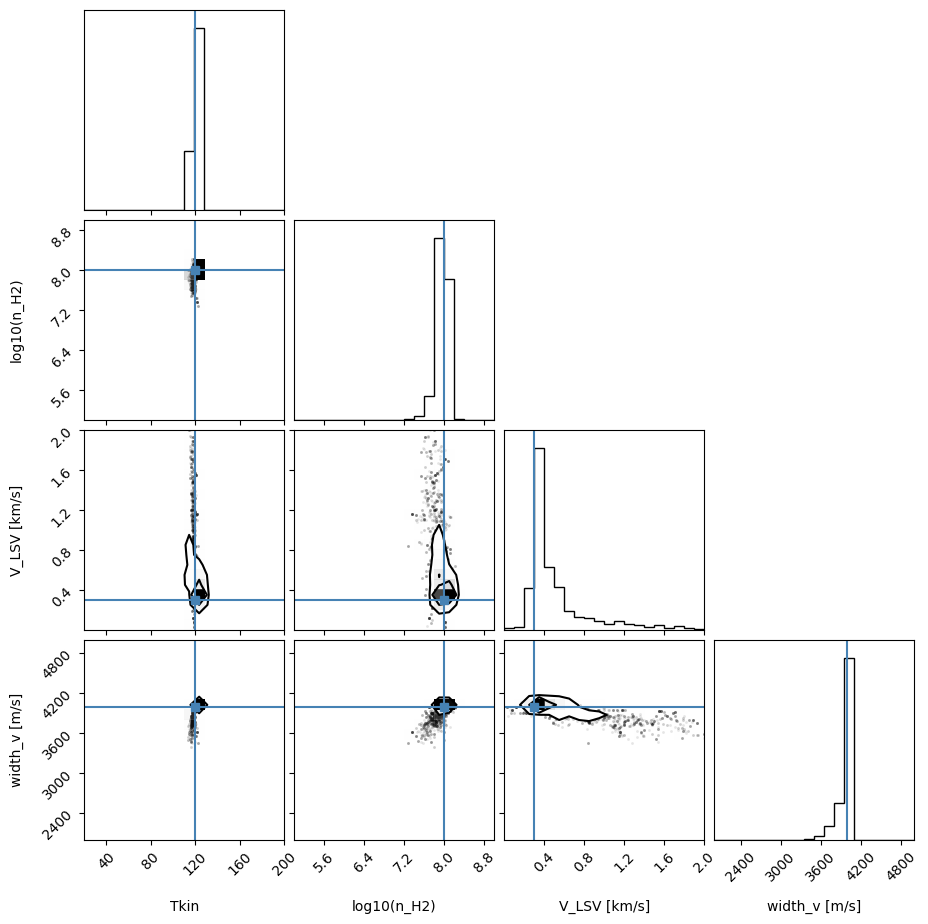

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


In [12]:
# Discard burn-in and flatten the chain
burnin = int(0.3 * nsteps)
samples = sampler.get_chain(discard=burnin, flat=True)
print("Mean parameter estimates [Tkin, log10(n_H2), V_LSV [km/s], width_v [m/s]]:")
print(np.mean(samples, axis=0))

# Define the range for each parameter
param_ranges = [
    (20, 200),  # Tkin range
    (5, 9),  # log10(n_H2) range
    (0, 2),  # V_LSR range
    (2000, 5000),  # width_v range
]

# Create a corner plot for the posterior samples
fig_corner = corner.corner(
    samples,
    labels=["Tkin", "log10(n_H2)", "V_LSV [km/s]", "width_v [m/s]"],
    truths=[Tkin, np.log10(observed_spectrum_n_collider), V_LSR, width_v],
    range=param_ranges,
)

plt.show()

# Plot the best-fit model vs the observed spectrum
Tkin_best, log_n_H2_best, nu_offset_best, width_v_best = np.median(samples, axis=0)
model_best = simulate_spectrum_from_params(Tkin_best, log_n_H2_best, nu_offset_best, width_v_best)

Mean parameter estimates [Tkin, log10(n_H2), V_LSV [km/s], width_v [m/s]]:
[1.19388754e+02 7.96035289e+00 5.29919293e-01 3.95496918e+03]


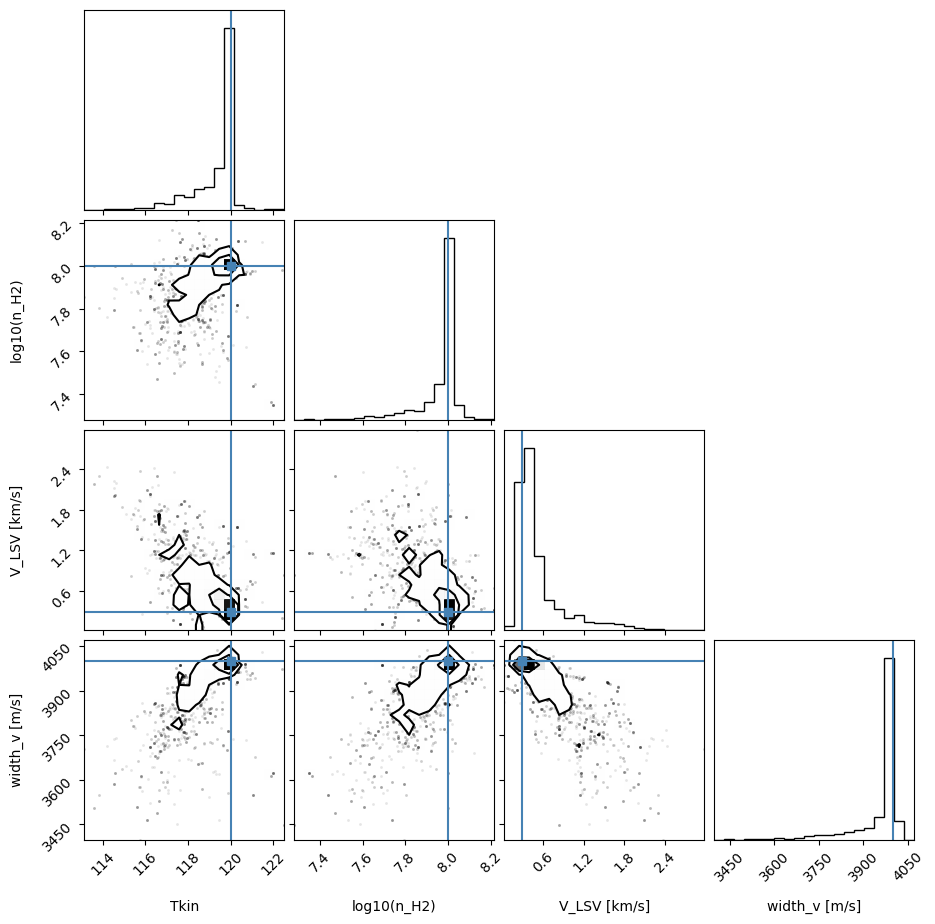

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


In [13]:
# Discard burn-in and flatten the chain
burnin = int(0.3 * nsteps)
samples = sampler.get_chain(discard=burnin, flat=True)
print("Mean parameter estimates [Tkin, log10(n_H2), V_LSV [km/s], width_v [m/s]]:")
print(np.mean(samples, axis=0))

# Create a corner plot for the posterior samples
fig_corner = corner.corner(
    samples, labels=["Tkin", "log10(n_H2)", "V_LSV [km/s]", "width_v [m/s]"], truths=[Tkin, np.log10(observed_spectrum_n_collider), V_LSR, width_v]
)

plt.show()

# Plot the best-fit model vs the observed spectrum
Tkin_best, log_n_H2_best, nu_offset_best, width_v_best = np.median(samples, axis=0)
model_best = simulate_spectrum_from_params(Tkin_best, log_n_H2_best, nu_offset_best, width_v_best)


Best fit parameters: Tkin = 119.87372200959841, log10(n_H2) = 7.995412832875882, V_LSV [km/s] = 0.38456724126174274, width_v [m/s] = 3994.2498973339943


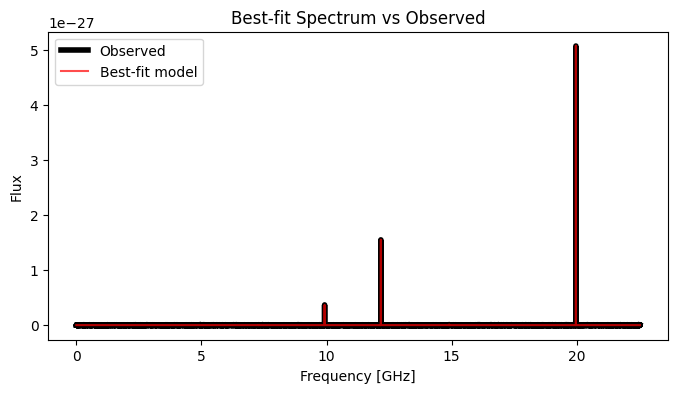

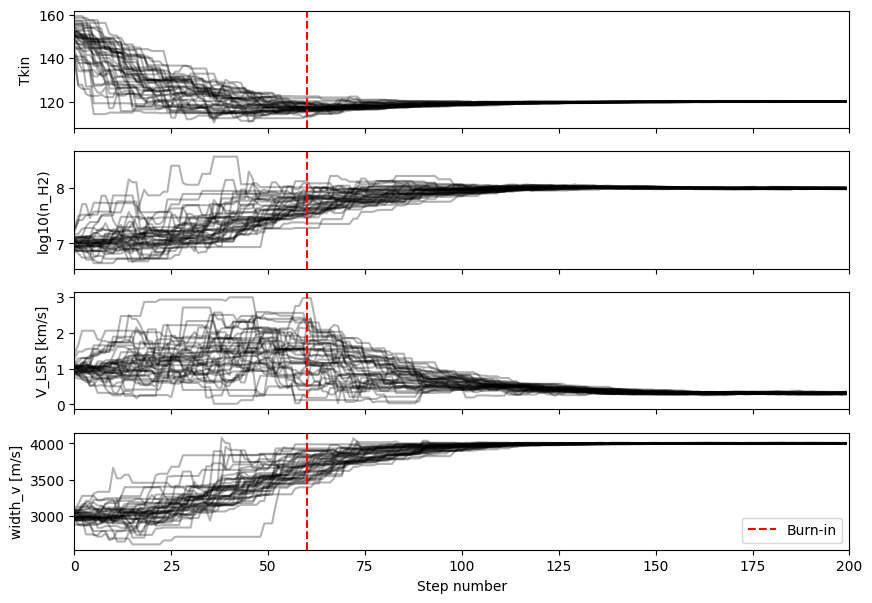

In [14]:
# print the best fit parameters
print(f"Best fit parameters: Tkin = {Tkin_best}, log10(n_H2) = {log_n_H2_best}, V_LSV [km/s] = {nu_offset_best}, width_v [m/s] = {width_v_best}")

plt.figure(figsize=(8, 4))
plt.plot(x / constants.giga, observed_spectrum, "k-", label="Observed", linewidth=4)
plt.plot(x / constants.giga, model_best, "r-", label="Best-fit model", alpha=0.7)
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.title("Best-fit Spectrum vs Observed")
plt.show()

# Plot trace plots for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Tkin", "log10(n_H2)", "V_LSR [km/s]", "width_v [m/s]"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.axvline(burnin, color="r", linestyle="--", label="Burn-in")
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.legend()
plt.show()

In [15]:
print("Tkin observed spectrum = ", Tkin)
print("log10(n_H2) observed spectrum = ", "{:.1e}".format(observed_spectrum_n_collider))
print("V_LSR observed spectrum = ", V_LSR)
print("width_v observed spectrum = ", width_v)

Tkin observed spectrum =  120
log10(n_H2) observed spectrum =  1.0e+08
V_LSR observed spectrum =  0.3
width_v observed spectrum =  4000.0


In [16]:
sys.exit("Stopping execution here")

SystemExit: Stopping execution here

C:\Users\alios\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Class to read and extract variables for specific k and j values 

In [ ]:
class MyClass:
    def __init__(self, cloud_name, data_of_molecule, column_density_species, width_v):
        """
        Initialize the class with the cloud object, the data of the molecule, the column density of the species, the width of the line

        Parameters
        ----------
        cloud_name : pythonradex.Cloud
            The cloud object.
        data_of_molecule : dict
            The data of the molecule. It should contain the levels, radiative transitions, quantum numbers, and the molecule name. This is the output of the LAMDA_file.read_file() function.
        column_density_species : float
            The column density of the species in m^2.
        width_v : float
            The width of the line in m/s
        Tkin : float
            The kinetic temperature in [K].
        """
        self.cloud_name = cloud_name
        self.data_of_molecule = data_of_molecule
        self.column_density_species = column_density_species
        self.width_v = width_v
        self.extract_and_calculate(debug=False)  # this allows optical_depth to use the extracted values from the extract_and_calculate method

    def get_transition_populations(self, names_transitions, debug=False):
        """
        Relates all the transitions in names_transitions with their corresponding population densities.

        Parameters
        ----------
        names_transitions: (list of str):
            List of transitions in the format ['79-78', '14-13', ...], where each element is a string with the format "upper_level-lower_level".

        Returns
        -------
            tuple: Two arrays, one for upper and one for lower populations density.
        """
        upper_populations = []
        lower_populations = []
        self.upper_level_transition_index = []
        self.lower_level_transition_index = []
        if debug:
            print("num_transitions:", len(names_transitions))

        for transition in names_transitions:
            upper_level, lower_level = map(int, transition.split("-"))  # split the string and convert to integers
            upper_pop = self.cloud_name.level_pop[upper_level]
            lower_pop = self.cloud_name.level_pop[lower_level]
            upper_populations.append(upper_pop)
            lower_populations.append(lower_pop)
            self.upper_level_transition_index.append(upper_level)
            self.lower_level_transition_index.append(lower_level)

        nu = np.array(upper_populations)
        nl = np.array(lower_populations)
        # compute upper level population density, given by: fractional population density x total column density
        Nu = nu * self.column_density_species
        Nl = nl * self.column_density_species
        return Nu, Nl

    def extract_and_calculate(self, debug=False):
        """
        Extract values from the cloud object and the data file, and calculate gamma factor

        Parameters
        ----------
        debug : boolean, optional
            If True, print debugging information. Default is False.

        Returns
        --------
        Tex: np.array
            The excitation temperature of the molecule.
        tau: np.array
            The optical depth of the transitions.
        Aul : np.array
            The Einstein coefficient for spontaneous emission [s^-1].
        Bul : np.array
            The Einstein coefficient for stimulated emission in [sr m2 Hz / Jy].
        nu0_array : np.array
            The rest frequency of the transition in Hz.
        Eu : np.array
            The energy of the upper level in [K].
        gu : np.array
            The statistical weight of the upper level.
        gamma: np.array
            Gamma factors, which is calculated using: gamma = (8 * np.pi * k * nu0**2) / (h * c**3 * Aul)
        Nu: np.array
            Upper level population density in [m-2].
        Nl: np.array
            Lower level population density in [m-2].
        FWHM_each_transition: np.array
            Frequency width of each transition in [Hz].
        """
        # Extract values
        self.Tex = self.cloud_name.Tex
        self.Aul = self.cloud_name.emitting_molecule.A21
        self.Bul = self.cloud_name.emitting_molecule.B21
        self.nu0_array = self.cloud_name.emitting_molecule.nu0
        self.tau = self.cloud_name.tau_nu(self.nu0_array)

        # levels = self.data_of_molecule["levels"]
        rad_transitions = self.data_of_molecule["radiative transitions"]

        # Extract upper energy levels in [J] and convert to Kelvin
        self.Eu = np.array([transition.up.E for transition in rad_transitions]) / constants.k

        # Get the statistical weight of the upper and lower levels
        self.gu = np.array([transition.up.g for transition in rad_transitions])
        self.glow = np.array([transition.low.g for transition in rad_transitions])

        # Get names of transitions
        names_transitions = np.array([tran.name for tran in rad_transitions])

        # Compute upper and lower level population densities
        self.Nu, self.Nl = self.get_transition_populations(names_transitions, debug=debug)

        # Convert velocity width to frequency width
        self.FWHM_each_transition = self.nu0_array * (self.width_v / constants.c)

        # Calculate gamma factor
        self.gamma = (8 * np.pi * constants.k * self.nu0_array**2) / (constants.h * constants.c**3 * self.Aul)

        if debug:
            # Debugging print statements
            print("Size of nu0_array:", len(self.nu0_array))
            print("Size of Eu:", len(self.Eu))
            print("E upper levels:", self.Eu)
            print("Size of gu:", len(self.gu))
            print("size exitation temperature Tex:", len(self.Tex))
            print(" gu:", self.gu)
            print("Size of glow:", len(self.glow))
            print(" glow:", self.glow)
            print("size Aul:", len(self.Aul))
            print("size FWHM_each_transition:", len(self.FWHM_each_transition))
            print("size gamma:", len(self.gamma))
            print("size Nu:", len(self.Nu))
            print("size Nl:", len(self.Nl))

        return (
            self.Tex,
            self.tau,
            self.Aul,
            self.Bul,
            self.nu0_array,
            self.Eu,
            self.gu,
            self.glow,
            self.gamma,
            self.Nu,
            self.Nl,
            self.FWHM_each_transition,
        )

    def get_selected_variables(self, k_quantum_number, j_lower_limit, j_upper_limit, debug=False):
        """
        Returns the variables in extract_and_calculate which have indices selected by the given k_quantum_number and J quantum number range.

        Parameters
        ----------
        k_quantum_number : str
            The k quantum number to filter the quantum numbers.
        j_lower_limit : int
            The ending J quantum number for filtering.
        j_upper_limit : int
            The starting J quantum number for filtering.
        debug : boolean, optional
            If True, print debugging information. Default is False.

        Returns
        -------
        dict
            Dictionary containing the selected variables.
        """
        indices = [
            i
            for i, (upper_transition, lower_transition) in enumerate(zip(self.upper_level_transition_index, self.lower_level_transition_index))
            if self.data_of_molecule["quantum numbers"][upper_transition].split("_")[1]
            == k_quantum_number  # this line is to ensure that the k quantum number is the specified value
            and j_lower_limit
            <= int(self.data_of_molecule["quantum numbers"][upper_transition].split("_")[0])
            <= j_upper_limit  # this line is to ensure that the J quantum number is within the specified range
            and np.abs(
                int(self.data_of_molecule["quantum numbers"][upper_transition].split("_")[1])
                - int(self.data_of_molecule["quantum numbers"][lower_transition].split("_")[1])
            )
            in [0, 1]  # this line is to ensure that the k quantum number difference is 0 or 1
            and np.abs(
                int(self.data_of_molecule["quantum numbers"][upper_transition].split("_")[0])
                - int(self.data_of_molecule["quantum numbers"][lower_transition].split("_")[0])
            )
            in [0, 1]  # this line is to ensure that the J quantum number difference is 0 or 1
        ]
        if debug:
            print("Indices of the transitions that have the selected k quantum number and J range", indices)
            print("upper level transition index", self.upper_level_transition_index)
            print("lower level transition index", self.lower_level_transition_index)

        # selected all the variable that have the specified k quantum number
        selected_vars = {
            "Tex": self.Tex[indices],
            "tau": self.tau[indices],
            "Aul": self.Aul[indices],
            "Bul": self.Bul[indices],
            "nu0_array": self.nu0_array[indices],
            "Eu": self.Eu[indices],
            "gu": self.gu[indices],
            "glow": self.glow[indices],
            "gamma": self.gamma[indices],
            "Nu": self.Nu[indices],
            "Nl": self.Nl[indices],
            "FWHM_each_transition": self.FWHM_each_transition[indices],
        }
        return selected_vars


In [ ]:
cloud_candidate = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)


def simulate_spectrum_from_params(Tkin_candidate, log_n_H2_candidate, V_LSR, width_v_candidate, debug=False):
    """Simulate a spectrum from multiple transitions for a given set of parameters

    Parameters
    ----------
    Tkin_candidate : float
        Kinetic temperature of the candidate cloud in K
    log_n_H2_candidate : float
        Logarithm of the H2 density of the candidate cloud in cm^-3
    V_LSR : float
        The velocity of the candidate cloud in km/s
    debug : bool, optional
        Print debug information, by default False"""

    # Convert log-density to linear density (matching your units)
    n_H2_candidate = 10 ** (log_n_H2_candidate) / constants.centi**3
    # Create a new cloud with the candidate width_v

    # check the parameter ranges
    assert 20 < Tkin_candidate < 500, f"Tkin_candidate out of range: {Tkin_candidate}"
    assert 2 < log_n_H2_candidate < 10, f"log_n_H2_candidate out of range: {log_n_H2_candidate}"
    # assert 0 < nu < 2000, f"nu_offset out of range: {nu}"

    cloud_candidate.update_parameters(
        N=N,
        Tkin=Tkin_candidate,
        collider_densities={"H2": n_H2_candidate},
        ext_background=ext_background,
        T_dust=T_dust,
        tau_dust=tau_dust,
    )
    # Suppress the print statements in solve_radiative_transfer
    with contextlib.redirect_stdout(io.StringIO()):
        cloud_candidate.solve_radiative_transfer()
    # Get the flux for the chosen transition
    flux_candidate = cloud_candidate.fluxes_of_individual_transitions(transitions=list(range(firstN_transitions)), solid_angle=source_solid_angle)

    # move the rest nu by V_LSR
    nu = nu0_arrayCH3OH * (1 - (V_LSR * 100) / constants.c)

    # width in freqancy space
    fwhm_candidate = nu0_arrayCH3OH * (width_v_candidate / constants.c)
    params = []
    for i in range(n_trans_spectrum):
        params.extend([flux_candidate[i], nu[i], fwhm_candidate[i]])

    # print("flux of spectrum ", flux_candidate)
    if debug:
        print("params ", params)
        print("nu ", nu)

    # Build the model line using the same Gaussian profile (center and fwhm_frequancy fixed)
    model_all_spectrum = model_spectrum(x, params)
    return model_all_spectrum

# MCMC on real data (HIFI data)

In [ ]:
file_path = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\methanolA_HIFIdata_k3.xlsx"
print(os.path.exists(file_path))

# read the excel file and convert it to a pandas dataframe
df = pd.read_excel(file_path)


True


## Functions defined in Population diagram notebook

In [ ]:
dataframe_filtered = df[
    ["Transition", "Eup(K)", "Aij", "FitFreq.(Mhz)", "deltaFitFreq.", "Vo(km/s)", "deltaVo", "FWHM_G(km/s)", "deltaFWHM_G", "Int[K]", "deltaInt"]
]

print(dataframe_filtered)

Aul = dataframe_filtered["Aij"]


# define Gaussian model for antenna temperature
def TA(v, V0, fwhm, T0):
    """
    Gaussian function to calculate the antenna temperature at a given velocity v,
    based on the mean velocity (V0), the full width at half maximum (fwhm),
    and the peak temperature (T0).
    """

    std = fwhm / (2 * np.sqrt(np.log(4)))  # calculate standard deviation from FWHM

    return T0 * np.exp(-0.5 * ((v - V0) / std) ** 2)


# define the flux (area under the Gaussian curve)
def flux(V0, fwhm, T0, v_range):
    """
    flux function integrates the antenna temperature function over the velocity range.
    """

    T = TA(v_range, V0, fwhm, T0)  # compute the antenna temperature for each v in the velocity range
    flux = np.trapezoid(T, v_range)  # use trapezium rule for integral

    return flux


def deltaflux(fwhm, delta_fwhm, deltaTo, T0, flux, V0):
    """
    delta flux function propagates the uncertainties in T0 and fwhm to the flux
    """

    # prepare partial derivatives for error propagation
    dflux_dT0 = flux / T0  # calculate derivative of flux with respect to T0
    dflux_dFWHM = flux / fwhm  # calculate derivative of flux with respect to FWHM

    # compute uncertainty in flux
    deltaflux = np.sqrt((dflux_dT0 * deltaTo) ** 2 + (dflux_dFWHM * delta_fwhm) ** 2)  # error propagation

    return deltaflux

                        Transition    Eup(K)      Aij  FitFreq.(Mhz)  \
0     E-CH3OH(3 -3   0 _ 2 -2   0)   68.7392  0.00584     912071.440   
1     E-CH3OH(3 -3   0 _ 3 -2   0)   68.7394  0.00122     766952.079   
2     E-CH3OH(4 -3   0 _ 3 -2   0)   78.0255  0.00556     960433.679   
3     E-CH3OH(4 -3   0 _ 4 -2   0)   78.0257  0.00171     766929.064   
4     E-CH3OH(5 -3   0 _ 5 -2   0)   89.6328  0.00195     766877.623   
5     E-CH3OH(5 -3   0 _ 4 -2   0)   89.6329  0.00562    1008772.016   
6     E-CH3OH(6 -3   0 _ 6 -2   0)  103.5600  0.00209     766779.921   
7     E-CH3OH(6 -3   0 _ 5 -2   0)  103.5608  0.00585    1057075.677   
8     E-CH3OH(7 -3   0 _ 6 -2   0)  119.8084  0.00620    1105324.509   
9     E-CH3OH(7 -3   0 _ 7 -2   0)  119.8090  0.00218     766616.154   
10    E-CH3OH(8 -3   0 _ 8 -2   0)  138.3775  0.00224     766364.968   
11    E-CH3OH(8 -3   0 _ 7 -2   0)  138.3776  0.00663    1153500.393   
12    E-CH3OH(9 -3   0 _ 9 -2   0)  159.2655  0.00227     765997

In [ ]:
# name relevant columns as variables
Vo = dataframe_filtered["Vo(km/s)"]
deltaVo = dataframe_filtered["deltaVo"]

FWHM = dataframe_filtered["FWHM_G(km/s)"]
deltaFWHM = dataframe_filtered["deltaFWHM_G"]

To = dataframe_filtered["Int[K]"]
deltaTo = dataframe_filtered["deltaInt"]

nu_hifi_mhz = dataframe_filtered["FitFreq.(Mhz)"]


v_ranges = [np.linspace(V0 - 3 * (fwhm / (2 * np.sqrt(np.log(4)))), V0 + 3 * (fwhm / (2 * np.sqrt(np.log(4)))), 1000) for V0, fwhm in zip(Vo, FWHM)]


In [ ]:
# Filter out rows where the frequency is below 800000 MHz
dataframe_filtered = dataframe_filtered[dataframe_filtered["FitFreq.(Mhz)"] >= 800000]

# name relevant columns as variables
Vo = dataframe_filtered["Vo(km/s)"]
deltaVo = dataframe_filtered["deltaVo"]

FWHM = dataframe_filtered["FWHM_G(km/s)"]
deltaFWHM = dataframe_filtered["deltaFWHM_G"]

To = dataframe_filtered["Int[K]"]
deltaTo = dataframe_filtered["deltaInt"]

nu_hifi_mhz = dataframe_filtered["FitFreq.(Mhz)"]

v_ranges = [np.linspace(V0 - 3 * (fwhm / (2 * np.sqrt(np.log(4)))), V0 + 3 * (fwhm / (2 * np.sqrt(np.log(4)))), 1000) for V0, fwhm in zip(Vo, FWHM)]


## Plot spectrum of HIFI data

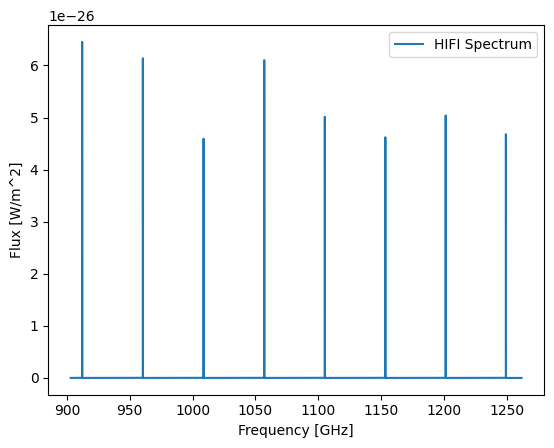

In [ ]:
# convert v0 to frequency Hz
nu_hifi = nu_hifi_mhz * 1e6

# width in frequency space
fwhm_hifi = nu_hifi * (FWHM * 1000 / constants.c)

# compute and store fluxes for all data points
fluxes_jansky = [flux(V0, fwhm, T0, v_range) for V0, fwhm, T0, v_range in zip(Vo, fwhm_hifi, To, v_ranges)]

# convert flux from Jansky to watts per square meter
fluxes = np.array(fluxes_jansky) * 1e-26

# generate frequency space
x = np.linspace(min(nu_hifi) * 0.99, max(nu_hifi) * 1.01, int(1e6))

# Define parameters for the HIFI data
params_hifi = []
for i in range(len(nu_hifi)):
    params_hifi.extend([fluxes[i], nu_hifi.iloc[i], fwhm_hifi.iloc[i]])

# Generate the spectrum
spectrum_hifi = model_spectrum(x, params_hifi)

noise_hifi_flux = 0.0005 * np.max(spectrum_hifi)

# Plot the spectrum
fig, ax = plt.subplots()
plt.plot(x / constants.giga, spectrum_hifi, label="HIFI Spectrum")
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"Flux [W/m^2]")
plt.legend()
plt.show()


Running MCMC... (this may take a while)


MCMC Sampling:   0%|          | 0/20 [00:00<?, ?step/s]c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')
MCMC Sampling: 100%|██████████| 20/20 [01:32<00:00,  4.62s/step]


Mean parameter estimates [Tkin, log10(n_H2), V_LSV [km/s], width_v [m/s]]:
[1.00564239e+02 7.18502527e+00 1.20323901e+00 4.00678310e+03]


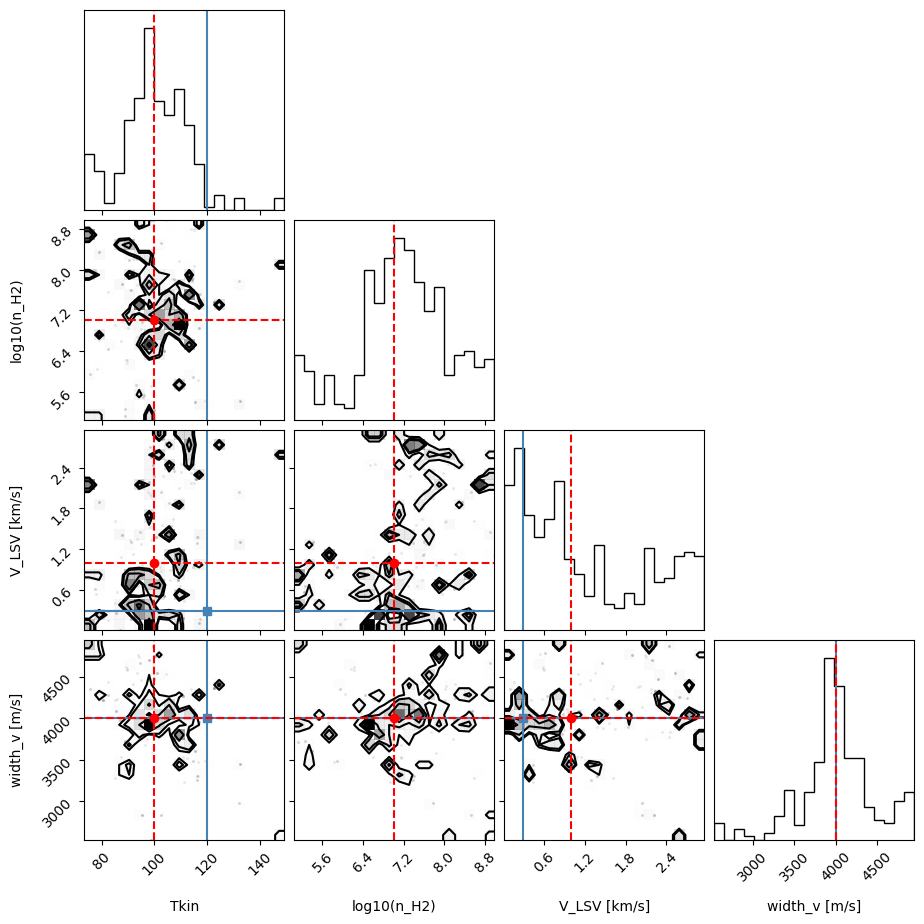

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


Best fit parameters: Tkin = 99.80985618353202, log10(n_H2) = 7.163335498515007, V_LSV [km/s] = 0.87317962262372, width_v [m/s] = 3988.858117384659


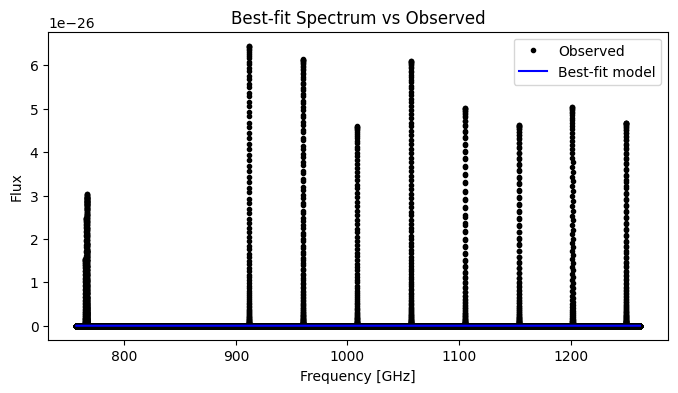

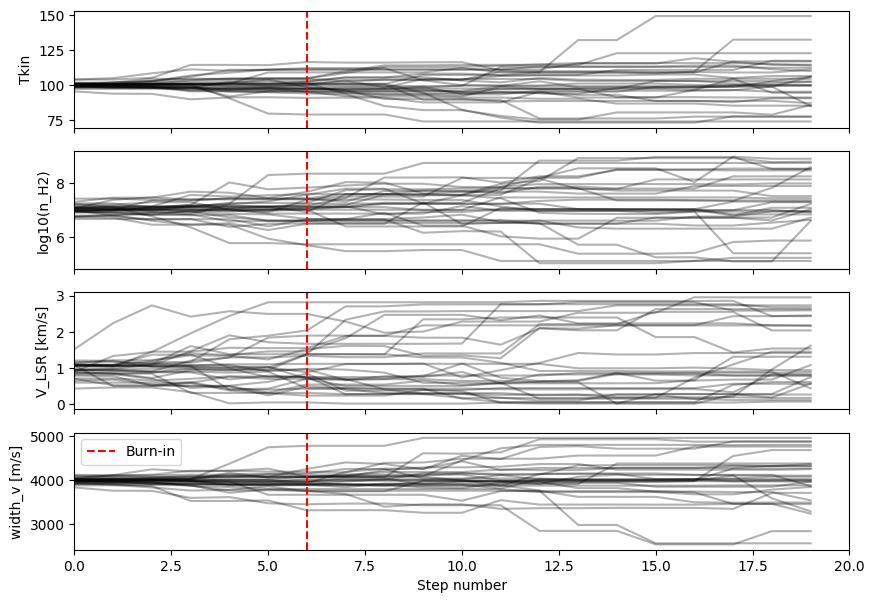

In [ ]:
# Initial guess for the parameters [Tkin, width_v, log10(n_H2)]
initial_tkin = 100
initial_log_n_H2 = 7
initial_offset = 1
initial_width_v = 4000

initial = np.array([initial_tkin, initial_log_n_H2, initial_offset, initial_width_v])

ndim = len(initial)
nwalkers = 30
# Define noise levels for each parameter
noise_levels = np.array([1, 0.1, 0.1, 50])  # Adjust these values as needed

# Initialize walkers in a small Gaussian ball around the initial guess
pos = initial + noise_levels * np.random.randn(nwalkers, ndim)

print("Running MCMC... (this may take a while)")
nsteps = 20
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, spectrum_hifi, noise_hifi_flux))
with tqdm(total=nsteps, desc="MCMC Sampling", unit="step") as pbar:
    for result in sampler.sample(pos, iterations=nsteps, progress=False):  # Disable emcee's built-in progress bar
        pbar.update(1)  # Update tqdm progress bar

# Discard burn-in and flatten the chain
burnin = int(0.3 * nsteps)
samples = sampler.get_chain(discard=burnin, flat=True)
print("Mean parameter estimates [Tkin, log10(n_H2), V_LSV [km/s], width_v [m/s]]:")
print(np.mean(samples, axis=0))

# Create a corner plot for the posterior samples
fig_corner = corner.corner(
    samples, labels=["Tkin", "log10(n_H2)", "V_LSV [km/s]", "width_v [m/s]"], truths=[Tkin, observed_spectrum_n_collider, V_LSR, width_v]
)

# Add initial guess
corner.overplot_lines(fig_corner, initial, color="red", linestyle="--")
corner.overplot_points(fig_corner, initial[None], marker="o", color="red")
plt.show()

# Plot the best-fit model vs the observed spectrum
Tkin_best, log_n_H2_best, nu_offset_best, width_v_best = np.median(samples, axis=0)
model_best = simulate_spectrum_from_params(Tkin_best, log_n_H2_best, nu_offset_best, width_v_best)

# print the best fit parameters
print(f"Best fit parameters: Tkin = {Tkin_best}, log10(n_H2) = {log_n_H2_best}, V_LSV [km/s] = {nu_offset_best}, width_v [m/s] = {width_v_best}")

plt.figure(figsize=(8, 4))
plt.plot(x / constants.giga, spectrum_hifi, "k.", label="Observed")
plt.plot(x / constants.giga, model_best, "b-", label="Best-fit model")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.title("Best-fit Spectrum vs Observed")
plt.show()

# Plot trace plots for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Tkin", "log10(n_H2)", "V_LSR [km/s]", "width_v [m/s]"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.axvline(burnin, color="r", linestyle="--", label="Burn-in")
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.legend()
plt.show()
